In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

In [3]:
# Data caracteristics
NUM_TRAIN_IMAGES = 100000
IMAGE_DIM = 48
TEMPLATE_DIM = 128

# Reader caracteristics
BATCH_SIZE = 256
NUM_READ_THREADS = 1
MIN_AFTER_DEQUEUE = 10000
CAPACITY = 11000

In [23]:
with open('data/data_train.bin', 'rb') as f:
    train_data = np.fromfile(f, dtype=np.uint8)
    train_data = train_data.reshape(NUM_TRAIN_IMAGES, IMAGE_DIM, IMAGE_DIM)

with open('data/fv_train.bin', 'rb') as f:
    template_data = np.fromfile(f, dtype=np.float32)
    template_data = template_data.reshape(NUM_TRAIN_IMAGES, TEMPLATE_DIM)

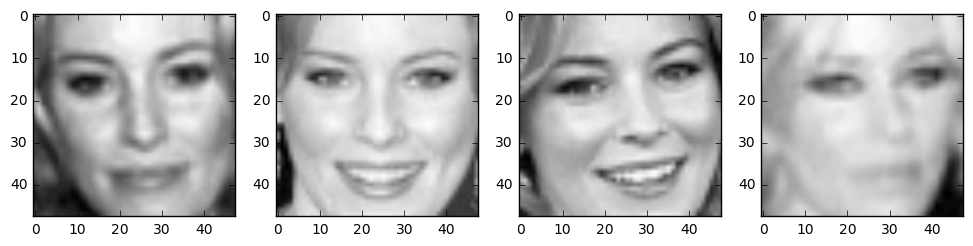

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
rand = np.random.randint(0, NUM_TRAIN_IMAGES)
for i, ax in enumerate(axes):
    ax.imshow(train_data[i + rand], cmap=plt.cm.gray)

In [6]:
def read_example_data(image_input_queue, template_input_queue):
    
    template_bytes = TEMPLATE_DIM * 4
    image_bytes = IMAGE_DIM * IMAGE_DIM
  
    template_reader = tf.FixedLengthRecordReader(template_bytes)
    image_reader = tf.FixedLengthRecordReader(image_bytes)
    
    _, template_value = template_reader.read(template_input_queue)
    _, image_value = image_reader.read(image_input_queue)
    
    template = tf.reshape(tf.decode_raw(template_value, tf.float32), [TEMPLATE_DIM])
    image = tf.reshape(tf.cast(tf.decode_raw(image_value, tf.uint8), tf.float32),
                       [IMAGE_DIM, IMAGE_DIM])        
    return image, template

In [7]:
def generate_image_and_template_batch(image, template, batch_size):
    
    image_batch, template_batch = tf.train.shuffle_batch(
        [image, template],
        batch_size=batch_size,
        num_threads=NUM_READ_THREADS,
        capacity=CAPACITY,
        min_after_dequeue=MIN_AFTER_DEQUEUE)

    return image_batch, template_batch

In [10]:
def get_batch_data(data_dir, batch_size):
    images_filename = [os.path.join(data_dir, 'data_train.bin')]
    templates_filename = [os.path.join(data_dir, 'fv_train.bin')]

    for f in images_filename + templates_filename:
        if not tf.gfile.Exists(f):
            raise ValueError('Failed to find file: ' + f)

    image_input_queue = tf.train.string_input_producer(images_filename)
    template_input_queue = tf.train.string_input_producer(templates_filename)  
    image, template = read_example_data(image_input_queue, template_input_queue)
    
    return generate_image_and_template_batch(image, template, batch_size)

In [ ]:
image_batch, template_batch = get_batch_data('data', BATCH_SIZE)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for j in range(1000):
        start = time()
        images, templates = sess.run([image_batch, template_batch])

    coord.request_stop()
    coord.join(threads)